## GPT1의 구조
1. Step1: unlabeled 된 데이터를 활용하여 Pretrained NN을 만든다.
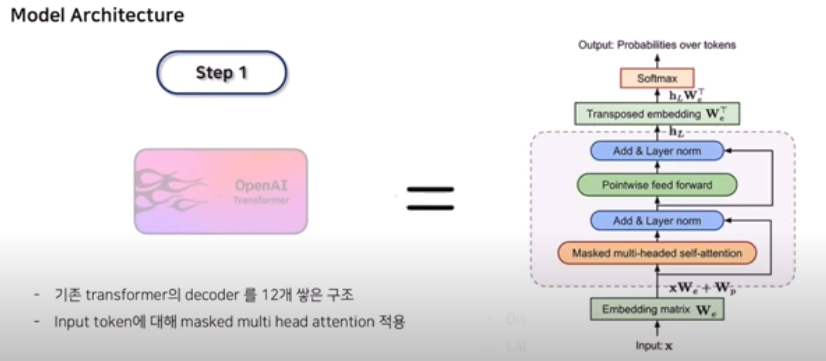
-기본적으로 Transformer의 Decoder 부분에서 Encoder-Decodr Multi-Head Attention 부분을 제거한 Decoder를 연속적으로 사용한다.
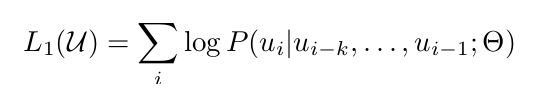
-Unsupervised Learning을 하는 경우 우리는 window 사이즈 만큼 데이터를 넣고 그 다음을 예측하는 문제가 된다.

2. Step2: labeled 된 데이터를 활용하여 Fine Tuning을 시킨다.
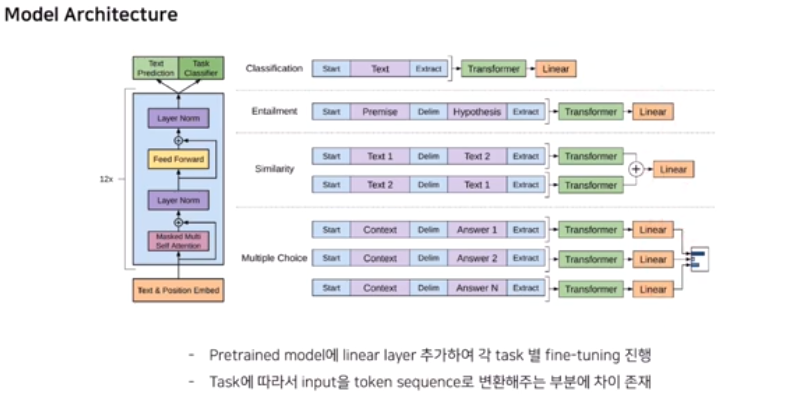
-이 경우에는 이제 labeled 된 데이터를 활용하기 때문에 Unsupervised Learning과 다르다.  
-즉, 데이터 셋이 2가지가 필요하게 된다!


In [1]:
import pandas as pd
import tensorflow as tf
import re
import numpy as np
import matplotlib.pyplot as plt

## 데이터 수집하기

In [2]:
df = pd.read_csv('Data/ChatbotData .csv')
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## 데이터 전처리

In [3]:
def preprocess_sentence2(sentence):
    
    sentence = sentence.strip() # 입력받은 sentence의 양쪽 공백을 제거
 
    sentence = re.sub(r"([.!?;~])+", r"\1", sentence)   # 연속된 구두점들을 하나의 구두점으로 변환
    sentence = re.sub(r"([?.!,;~])", r" \1 ", sentence) # 단어와 구두점 사이의 거리 추가 (토커나이저가 공백을 기준으로 단어를 분리하기에, 단어와 구두점이 붙어있음에 따른 의미 손실을 방지)
    sentence = re.sub(r'[" "]+', " ", sentence)         # 연속된 공백을 하나의 공백으로 축소
    
    # (a-z, A-Z, ".", "?", "!", ",", ";", "~")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣0-9a-zA-Z.?!,;~]+", " ", sentence)
    sentence = sentence.strip()  # 새로 추가됐을 수 있는 문장 양쪽의 공백을 제거
    return sentence

In [4]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations(df):
    inputs, outputs = [], []

    for line in df["Q"]:
        inputs.append(preprocess_sentence2(line))
    
    for line in df['A']: 
        outputs.append(preprocess_sentence2(line)) 

    return inputs, outputs

In [5]:
questions_p, answers_p =load_conversations(df)
print('전체 샘플 수 :', len(questions_p))
print('전체 샘플 수 :', len(answers_p))
print('전처리 후의 22번째 질문 샘플: {}'.format(questions_p[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers_p[21]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823
전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


In [6]:
## SubwordTextEncder 사용하기
import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions_p + answers_p,
                                                                      target_vocab_size=2**13)

In [7]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [8]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8158]
END_TOKEN의 번호 : [8159]


In [9]:
VOCAB_SIZE = tokenizer.vocab_size + 2 # 단어장 크기 더하기 2
print(VOCAB_SIZE)

8160


In [10]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions_p[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers_p[21])))

정수 인코딩 후의 21번째 질문 샘플: [5755, 610, 2486, 4156]
정수 인코딩 후의 21번째 답변 샘플: [2354, 7498, 7, 6262, 97, 1]


## Fine Tuning을 위한 데이터셋 확보

In [11]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [12]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [13]:
questions1, answers1 = tokenize_and_filter(questions_p, answers_p)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions1)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers1)))


단어장의 크기 : 8160
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [14]:
questions1[0]

array([8158, 7897, 4196, 3049,   35, 8159,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [15]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset_f = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions1,
        'dec_inputs': answers1[:, :-1]
    },
    {
        'outputs': answers1[:, 1:]
    },
))

dataset_f = dataset_f.cache()
dataset_f = dataset_f.shuffle(BUFFER_SIZE)
dataset_f = dataset_f.batch(BATCH_SIZE)
dataset_f = dataset_f.prefetch(tf.data.experimental.AUTOTUNE)

## Pretrained를 위한 데이터셋 준비

In [16]:
def encoding(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  encoded_dat = []
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  encoded_dat = tokenized_inputs + tokenized_outputs
  return encoded_dat

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 샘플 정수 인코딩된 한국어 데이터셋
encoded_data = encoding(questions_p, answers_p)


# Hyperparameters
sequence_length = 40  # 최대 시퀀스 길이
vocab_size = 10000  # 어휘 사전 크기
batch_size = 64
buffer_size = 10000

# 입력 시퀀스와 라벨을 생성하는 함수
def create_sequences(encoded_data, sequence_length):
    inputs = []
    labels = []
    
    for sequence in encoded_data:
        for i in range(1, len(sequence)):
            input_sequence = sequence[:i]
            label = sequence[i]
            inputs.append(input_sequence)
            labels.append(label)
    
    return inputs, labels

# 시퀀스 생성
inputs, labels = create_sequences(encoded_data, sequence_length)

# 시퀀스를 sequence_length로 패딩
inputs_padded = pad_sequences(inputs, maxlen=sequence_length, padding='pre')
labels = np.array(labels)

# TensorFlow 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((inputs_padded, labels))

# 데이터셋 셔플링 및 배치 처리
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

# 데이터셋 형태 확인
for batch_inputs, batch_labels in dataset.take(1):
    print("배치 입력 시퀀스 형태:", batch_inputs.shape)
    print("배치 라벨 형태:", batch_labels.shape)
print(len(dataset))

배치 입력 시퀀스 형태: (64, 40)
배치 라벨 형태: (64,)
2458


## Attention

In [18]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)   # 쿼리에 Dense 적용
    key = self.key_dense(key)         # 키에 Dense 적용
    value = self.value_dense(value)   # 값에 Dense 적용

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)  # 쿼리를 여러 헤드로 나눔
    key = self.split_heads(key, batch_size)      # 키를 여러 헤드로 나눔
    value = self.split_heads(value, batch_size)  # 값을 여러 헤드로 나눔

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

## Padding Mask

In [20]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [21]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

## Decoder Layer의 구조
-Encoder-Decodr Multi-Head Attention 부분을 제거한다.  
-Padding을 반드시 사용해야 한다. 데이터의 padding된 부분을 무시해야 되기 때문이다.

In [22]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 마스크드 셀프 어텐션 (Look-ahead mask + Padding mask)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs=inputs,
                                                                            key=inputs,
                                                                            value=inputs,
                                                                            mask=look_ahead_mask)

    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 피드포워드 네트워크
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # Dropout 및 LayerNormalization
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention1)

    return tf.keras.Model(inputs=[inputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

## Decoder의 구조
-GPT1의 경우 학습 가능한 Positional Embedding을 사용한다. 즉, Embedding Layer에 Postional한 정보를 같이 학습하게 되는 것이다!

In [23]:
def gpt1_decoder(vocab_size,
                 num_layers,
                 units,
                 d_model,
                 num_heads,
                 dropout,
                 name='gpt1_decoder'):
    # 입력 텐서
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    # encoder input은 없다!
    
    # 마스크 (Look-ahead mask만 사용)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))  # 임베딩 스케일링

    # 포지셔널 인코딩 (GPT-1은 학습 가능한 포지셔널 임베딩을 사용)
    pos_encoding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_model)(inputs)
    embeddings += pos_encoding

    # Dropout 적용
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # GPT-1에서는 인코더-디코더 어텐션이 없고, 마스크드 셀프 어텐션만 적용
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i)
        )(inputs=[outputs, look_ahead_mask])

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name
    )


## GPT 구조

In [26]:
def gpt1(vocab_size,
         num_layers,
         units,
         d_model,
         num_heads,
         dropout,
         name="gpt1"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # GPT-1에서 Look-ahead Mask 사용 (미래의 토큰을 마스크)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(inputs)

    # 패딩을 위한 마스크 (입력에 패딩이 있을 경우, 해당 위치 무시)
    padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='padding_mask')(inputs)

    # 디코더 (GPT-1은 디코더만 사용)
    dec_outputs = gpt1_decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, look_ahead_mask, padding_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)


    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [27]:
# 하이퍼파라미터
NUM_LAYERS = 12 # 디코더의 층의 개수
D_MODEL = 256 # 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

inner_model = gpt1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

TypeError: in user code:


    TypeError: tf__call() got an unexpected keyword argument 'key'


In [ ]:
# 출력층 (다음 단어 예측)
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
))

inner_model = gpt1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)
model = keras.Seqeuntial(
[
    keras.Input(shape = (40,),
    inner)
    
])

In [ ]:
print(VOCAB_SIZE)

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 12 # 디코더의 층의 개수
D_MODEL = 256 # 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

## Pretraining을 위한 Loss 함수 정의
-이 문제의 경우 categorical loss function을 사용해야 된다.

In [ ]:
import tensorflow as tf

def gpt1_loss_function(y_true, y_pred):
    """
    GPT-1 Pre-training을 위한 손실 함수.
    패딩된 토큰을 무시하고, 각 토큰에 대한 손실을 계산하여 평균 손실을 반환합니다.
    
    Args:
    y_true: 실제 정답 레이블 (정수형 토큰)
    y_pred: 모델의 예측 (logits 형태의 출력)
    
    Returns:
    평균 손실
    """
    # y_true를 y_pred의 시퀀스 길이에 맞춰 reshape
    y_true = tf.reshape(y_true, shape=(-1, tf.shape(y_pred)[-2]))

    # SparseCategoricalCrossentropy로 손실 계산 (logits이므로 from_logits=True)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # 패딩 토큰(0) 무시하기 위해 마스크 생성 (0이 아닌 곳만 True)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)

    # 마스크를 적용하여 패딩된 위치의 손실을 무시
    loss = tf.multiply(loss, mask)

    # 마스크가 적용된 손실의 평균을 반환
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

## 학습 과정(Pretraining 과정)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

## 학습 과정(Fine Tuning 과정)

## 모델 평가하기

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence2(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argma x(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
sentence_generation('오늘 비가 많이 오니?')